# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

## Physical Models of target and interceptor

In [2]:
from physics.missile import PhysicalMissleModel
import physics.math as physics
import numpy as np

interceptor_speed = physics.mach_to_ms(4.0)  # Speed of the interceptor in m/s
target_speed = physics.mach_to_ms(3.0)  # Speed of the target in m/s

target_init_velocty = np.array([target_speed * 0.707, target_speed * 0.707, 0.0]) # in a 45 degree angle

target = PhysicalMissleModel(velocity=target_init_velocty, max_acc=100 * 9.81, pos=np.array([-5_000.0, -5_000.0, 20_000.0]))
interceptor = PhysicalMissleModel(velocity=np.array([0.0, 0.0, interceptor_speed]), max_acc=100 * 9.81, pos=np.array([0.0, 0.0, 1000.0]))

## Environment & Gym

In [3]:
from environment.environment import MissileEnv, MissileEnvSettings
from pilots.random_evasion_pilot import RandomEvasionPilot
from pilots.constant_acc_pilot import ConstantAccelerationPilot
from stable_baselines3.common.monitor import Monitor
from visualization.matplot_viz import MatplotVisualizer

# target behavior
target_pilot = RandomEvasionPilot()
# target_pilot = ConstantAccelerationPilot(acc=np.array([0.2, 0.0]))
# target_pilot = None # keep trajectory

settings = MissileEnvSettings()
settings.time_step = 0.1    # Time step for the simulation
settings.realtime = False    # Runs faster than real-time
settings.time_limit = 50.0  # Time-limit for the episode
env = MissileEnv(settings=settings, target=target, interceptor=interceptor, target_pilot=target_pilot)

viz = MatplotVisualizer()

# Proportional Guidance

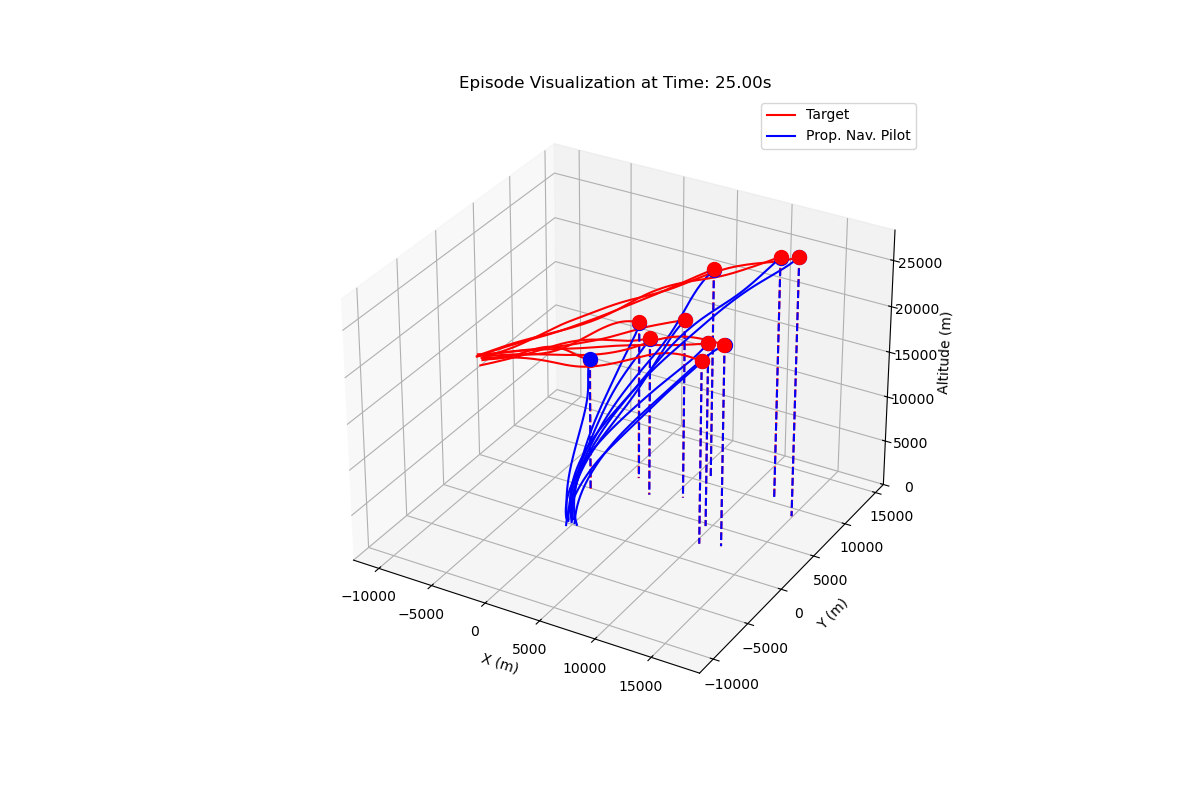

In [4]:
from pilots.proportional_nav_pilot import PlanarProportionalNavPilot, ZemProportionalNavPilot, SpaceProportionalNavPilot
from visualization.matplot_viz import MatplotVisualizer
import time


# setup pilots
proportional_nav_pilot = ZemProportionalNavPilot(max_acc=100*9.81, n=7)

max_sim_time = 0.0
episodes = 10
env.uncertainty = 0.3
env.set_current_agent_name("Prop. Nav. Pilot")

viz.reset()

for i in range(episodes):
    done = False
    obs, _ = env.reset()

    while not done:
        # get un-normalized observations for the interceptor (environment outputs normalized observations for RL agent)
        obs = env.get_interceptor_observations(settings.time_step).pack()

        # pilot the interceptor using the proportional navigation algorithm
        action = proportional_nav_pilot.step(obs, settings.time_step, interceptor, target)

        obs, reward, done, _, _ = env.step(action)  # Take a step in the environment

    # Record the best distance for this episode
    max_sim_time = max(max_sim_time, env.sim_time)
    viz.add_episode_data(env.current_episode)


viz.render(max_sim_time)
# viz.save_playback("prop-nav.gif", max_sim_time, 5.0, 10)

In [ ]:
viz.save_playback("./.playbacks/prop-nav.gif", max_sim_time, 5.0, 10)

# Reinforcement Learning Agents

## Soft Actor-Critic

In [5]:
from stable_baselines3 import SAC
from tqdm import tqdm
import os

monitored_env = Monitor(env) # required for convergence check in callback

# SAC model hyperparameters
entropy_coef = "auto"  # Automatically adjust entropy coefficient
target_entropy = "auto"  # Target entropy for the policy
device = "cuda"    

# values by optuna
net_arch = [128, 128, 128]
learning_rate = 0.00172
buffer_size = 7000
tau = 0.0258
gamma = 0.902

In [6]:
from stable_baselines3 import SAC

model = SAC("MlpPolicy", monitored_env, 
            verbose=1, 
            tensorboard_log="./.logs/sac", 
            device=device, 
            # learning_rate=learning_rate,
            # buffer_size=buffer_size,
            # tau=tau,
            # gamma=gamma,
            # policy_kwargs=dict(net_arch=net_arch),
        )

Using cuda device
Wrapping the env in a DummyVecEnv.


In [ ]:
# check if snapshot file exists
snapshot_path = "./.snapshots/snapshot-sac.zip"
if os.path.exists(snapshot_path):
    model = SAC.load(snapshot_path, env=monitored_env, 
                    device=device, 
                    learning_rate=learning_rate,
                    buffer_size=buffer_size,
                    tau=tau,
                    gamma=gamma,
            )
    print("Loaded existing model from snapshot.")
else:
    print("No existing model snapshot found")

## Training

In [7]:
from util.convergence_callback import ConvergenceCallback
from util.save_on_episode_end import SaveOnEpisodeEnd
from stable_baselines3.common.callbacks import CallbackList

def get_best_distance(episode):
    # get the best distance between the interceptor and the target
    return min([state.distance for time, state in episode.get_interceptor(env.current_agent_name).states.all.items()])

def eval_model(model, save_gif=False):
    eval_distances = []
    max_sim_time = 0.0

    if save_gif:
        viz.reset()

    for _ in range(10):
        done = False
        while not done:
            obs = env.get_interceptor_observations(settings.time_step).pack()
            action, _ = model.predict(obs, deterministic=True)
            obs, _, done, _, _ = env.step(action)

        best_distance = get_best_distance(env.current_episode)
        eval_distances.append(best_distance)

        if save_gif:
            viz.add_episode_data(env.current_episode)
            max_sim_time = max(max_sim_time, env.sim_time)
    
    mean_distance = np.mean(eval_distances)
    print(f"Mean distance: {mean_distance:.2f} m")

    if save_gif:
        viz.save_playback(f"./.playbacks/last-eval.gif", max_sim_time, 10.0, 4)

    return mean_distance

def train_until_miss_distance(model, model_name="rl", distance=100.0):
    best_mean_distance = float('inf')

    first_run = True
    complete = False
    while not complete:    
        with tqdm(total=20_000, desc="Training Progress", unit="steps") as pbar:
            model.learn(total_timesteps=20_000, progress_bar=pbar, reset_num_timesteps=first_run)
            first_run = False

        mean_distance = eval_model(model)
        print(f"Current mean miss distance training: {mean_distance:.2f} m")

        if mean_distance < best_mean_distance:
            best_mean_distance = mean_distance
            model.save(f"./.snapshots/snapshot-{model_name}")
            print(f"New best model saved with mean miss distance: {best_mean_distance:.2f} m")

        if mean_distance < distance:
            complete = True
            print(f"Training complete! Mean miss distance: {mean_distance:.2f} m")

def train_until_convergence(model, model_name="rl", reward_variance_threshold=200):
    convergence_callback = ConvergenceCallback(10, reward_variance_threshold)
    save_model_callback = SaveOnEpisodeEnd(save_dir="./.snapshots", model_name=model_name)

    callbacks = CallbackList([convergence_callback, save_model_callback])

    max_timesteps = 1_000_000

    with tqdm(total=max_timesteps, desc="Training Progress", unit="steps") as pbar:
        model.learn(total_timesteps=max_timesteps, callback=callbacks, progress_bar=pbar, reset_num_timesteps=False)

    model.save(f"./.snapshots/converged-{model_name}")

In [ ]:
env.uncertainty = 0.2
total_iterations = 50_000
step_size = 5_000

first_run = True
for i in range(total_iterations // step_size):
    print(f"Training iteration {i + 1}/{total_iterations // step_size}")
    
    # Train the model for a step size
    model.learn(total_timesteps=step_size, reset_num_timesteps=first_run, progress_bar=True)
    first_run = False

    # Evaluate the model and output a gif
    mean_distance = eval_model(model, True)
    print(f"Mean distance after {i + 1} iterations: {mean_distance:.2f} m")



### Curriculum Learning

In [ ]:
env.uncertainty = 0.1
train_until_miss_distance(model, "sac-uncertainty-1", 100.0)
model.save("./.snapshots/best-sac")

env.uncertainty = 0.2
train_until_miss_distance(model, "sac-uncertainty-2", 100.0)
model.save("./.snapshots/best-sac")

env.uncertainty = 0.3
train_until_miss_distance(model, "sac-uncertainty-3", 100.0)
model.save("./.snapshots/best-sac")

env.uncertainty = 0.4
train_until_miss_distance(model, "sac-uncertainty-4", 100.0)
model.save("./.snapshots/best-sac")

### Hyperparameter Search (Optuna)

In [ ]:
import optuna
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import EvalCallback
from tqdm import tqdm

def sample_sac_params(trial: optuna.Trial):
    net_depth = trial.suggest_int("net_depth", 2, 6, step=1)
    net_width = trial.suggest_int("net_width", 64, 512, step=64)
    net_arch = [net_width] * net_depth
    policy_kwargs = dict(net_arch=net_arch)

    return {
        "policy_kwargs": policy_kwargs,
    }

# 2. Evaluation callback for pruning
class TrialEvalCallback(EvalCallback):
    def __init__(self, eval_env, trial, n_eval_episodes=3, eval_freq=2_000):
        super().__init__(eval_env, eval_freq=eval_freq, n_eval_episodes=n_eval_episodes, verbose=0)
        self.trial = trial
        self.is_pruned = False

    def _on_step(self) -> bool:
        for info in self.locals.get('infos', []):
            if 'episode' in info:
                self.trial.report(self.last_mean_reward, self.n_calls)
                if self.trial.should_prune():
                    self.is_pruned = True
                    return False

        return True

# 3. Objective function
def objective(trial: optuna.Trial) -> float:
    total_timesteps = 50_000

    monitored_env = Monitor(env)  # Required for convergence check in callback

    kwargs = sample_sac_params(trial)
    model = SAC("MlpPolicy", monitored_env, device="cuda", verbose=0, tensorboard_log="./.logs/sac_optuna", **kwargs)

    print(f"Trial {trial.number} parameters: {kwargs}")

    eval_callback = TrialEvalCallback(monitored_env, trial)

    try:
        with tqdm(total=total_timesteps, desc="Training Progress", unit="steps") as pbar:
            model.learn(total_timesteps=total_timesteps, callback=eval_callback, progress_bar=pbar)
    except Exception as e:
        print(f"Error during training: {e}")
        return float("nan")

    if eval_callback.is_pruned:
        raise optuna.exceptions.TrialPruned()

    return eval_callback.last_mean_reward

In [ ]:
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

sampler = TPESampler(n_startup_trials=10, multivariate=True)
pruner = MedianPruner(n_startup_trials=10, n_warmup_steps=1)
study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)

env.uncertainty = 0.0 
study.optimize(objective, n_trials=50, timeout=14400)

print("Best trial:", study.best_trial.params)

### Inference

In [9]:
# Extract reward components over time
def create_reward_plot(infos):
    times = list(infos.keys())
    dist_rewards = [info["dist-reward"] for info in infos.values()]
    closing_rate_rewards = [info["closing-rate-reward"] for info in infos.values()]
    event_rewards = [info["event-reward"] for info in infos.values()]
    action_punishments = [info["action-punishment"] for info in infos.values()]
    ground_penalties = [info["ground-penality"] for info in infos.values()]
    rewards = [info["reward"] for info in infos.values()]

    # Create the plot
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 8))
    plt.plot(times, dist_rewards, label="Distance Reward")
    plt.plot(times, closing_rate_rewards, label="Closing Rate Reward")
    plt.plot(times, event_rewards, label="Event Reward")
    plt.plot(times, action_punishments, label="Action Punishment")
    plt.plot(times, ground_penalties, label="Ground Penalty")
    plt.plot(times, rewards, label="Total Reward", linestyle='--', color='black', linewidth=2.5)

    plt.xlabel("Time (s)")
    plt.ylabel("Reward Components")
    plt.title("Reward Components Over Time")
    plt.legend()
    plt.grid(True)
    
    return plt

def render_reward_plot(infos):
    plt = create_reward_plot(infos)
    plt.show()
    plt.show(block=False)

def save_reward_plot(infos, filename):
    plt = create_reward_plot(infos)
    plt.savefig(filename)
    plt.close()

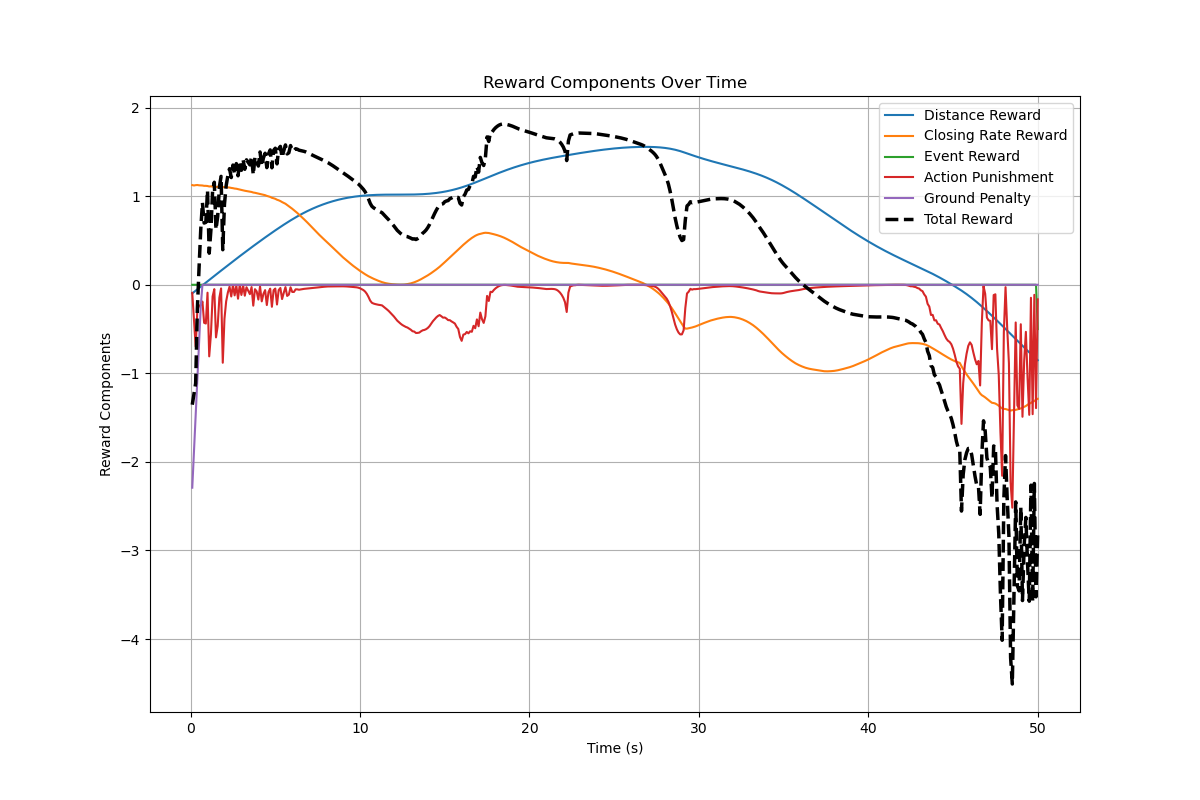

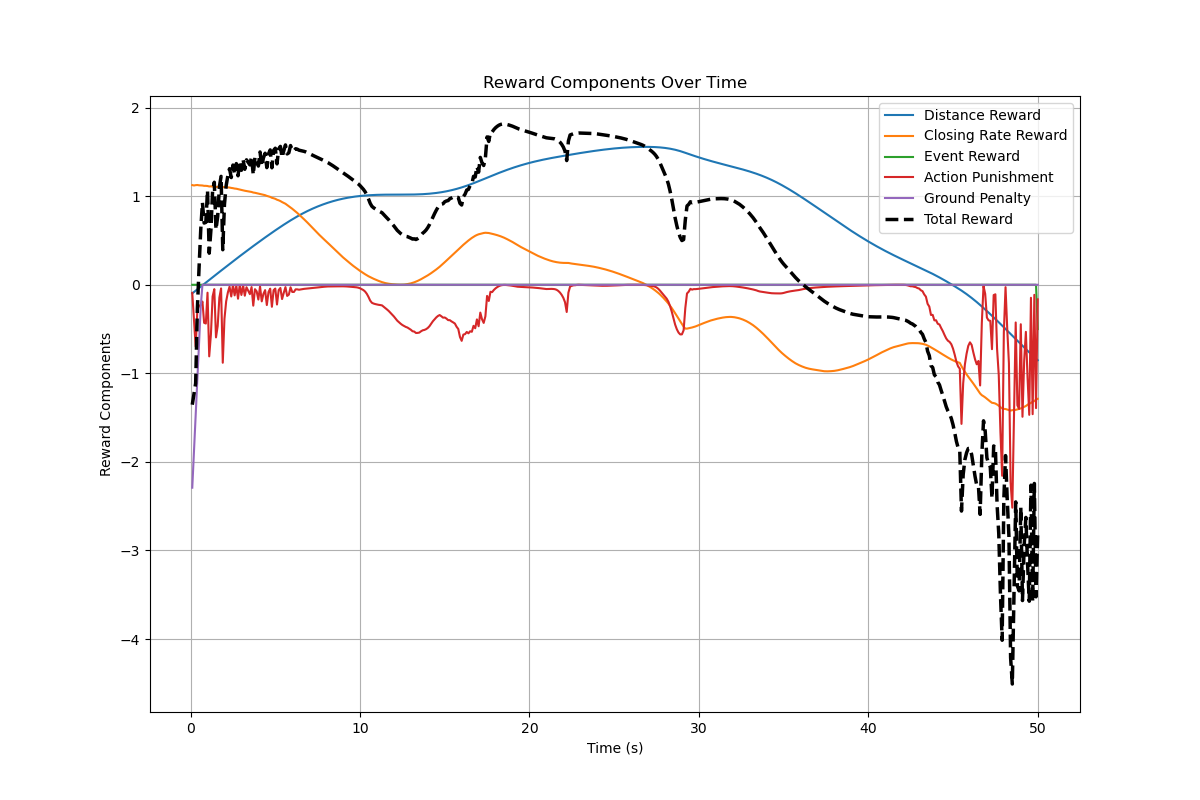

In [14]:
from stable_baselines3.sac import SAC

env.uncertainty = 0.2
# model = SAC.load("./best-sac.zip", env=env, device="cuda")

obs, _ = env.reset()
done = False
infos = {}
while not done:
    # action = proportional_nav_pilot.step(obs, settings.time_step, interceptor, target)
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, _, info = env.step(action)
    infos[env.sim_time] = info

render_reward_plot(infos)
# viz.set_episode_data(env.current_episode)
# viz.render(env.sim_time)

# Results

## Evaluate

In [ ]:
from stable_baselines3 import SAC

best_distances = []

# model = SAC.load("./.snapshots/snapshot-sac-uncertainty-1.zip", env=env, device="cuda")

viz.reset()
max_sim_time = 0.0
episodes = 10
env.uncertainty = 0.2

for i in range(episodes):
    obs, _ = env.reset()
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, done, _, _ = env.step(action)
        
    distances = [state.distance for time, state in env.current_episode.get_interceptor(env.current_agent_name).states.all.items()]
    best_distances.append(min(distances))

    max_sim_time = max(max_sim_time, env.sim_time)
    viz.add_episode_data(env.current_episode)

best_distance = min(best_distances)
worst_distance = max(best_distances)
mean_distance = np.mean(best_distances)
print(f"Best Distance: {best_distance:.2f} m | Worst Distance: {worst_distance:.2f} | Mean Distance: {mean_distance:.2f} m")

# render
viz.render(max_sim_time)
# viz.save_playback("sac.gif", max_sim_time, 5.0, 10)

### Compare with Proportional Navigation

In [ ]:
episodes = 30
env.uncertainty = 0.5

agent_miss_distances = []
prop_nav_miss_distances = []

for i in range(episodes):
    obs, _ = env.reset()
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, done, _, _ = env.step(action)

    distances = [state.distance for time, state in env.current_episode.get_interceptor(env.current_agent_name).states.all.items()]
    agent_miss_distances.append(min(distances))

for i in range(episodes):
    obs, _ = env.reset()
    done = False
    while not done:
        action = proportional_nav_pilot.step(obs, settings.time_step, interceptor, target)
        obs, rewards, done, _, _ = env.step(action)

    distances = [state.distance for time, state in env.current_episode.get_interceptor(env.current_agent_name).states.all.items()]
    prop_nav_miss_distances.append(min(distances))

In [ ]:
agent_mean_miss_distance = np.mean(agent_miss_distances)
prop_nav_mean_miss_distance = np.mean(prop_nav_miss_distances)
print(f"Agent Mean Miss Distance: {agent_mean_miss_distance:.2f} m | Proportional Nav Mean Miss Distance: {prop_nav_mean_miss_distance:.2f} m")

agent_hit_rate = np.mean(np.array(agent_miss_distances) < 50.0)
prop_nav_hit_rate = np.mean(np.array(prop_nav_miss_distances) < 50.0)
print(f"Agent Hit Rate: {agent_hit_rate:.2f} | Proportional Nav Hit Rate: {prop_nav_hit_rate:.2f}")

## Save and Playback

In [ ]:
for id, interceptor_state in env.current_episode.interceptors.items():
    distances = [state.distance for time , state in interceptor_state.states.all.items()]
    best_distance = min(distances)
    print (f"Interceptor {id} best distance: {best_distance:.2f} m")

viz.set_episode_data(env.current_episode)
viz.save_playback("output.gif", env.sim_time, 5.0, 5)

## Plot Distance over time

In [ ]:
# get all distances from the interceptor to the target
distances = {time: state.distance for time, state in env.current_episode.get_interceptor(env.current_agent_name).states.all.items()}

import matplotlib.pyplot as plt
import numpy as np

times = list(distances.keys())
distance_values = list(distances.values())

plt.figure(figsize=(10, 6))
plt.plot(times, distance_values, label="Distance over Time")

# Find the minimum value and its corresponding time
min_distance = min(distance_values)
min_time = times[distance_values.index(min_distance)]

# Add a label for the minimum value
plt.scatter(min_time, min_distance, color='red', label=f"Min Distance: {min_distance:.2f} m")
plt.text(min_time, min_distance, f"({min_time:.2f}, {min_distance:.2f})", color='red', fontsize=10)

plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.title("Interceptor to Target Distance Over Time")
plt.legend()
plt.grid(True)
plt.show()